## Import necessary libraries

In [274]:
%reset -f
import pandas as pd

import pickle
import numpy
import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
import xgboost as xgb
from matplotlib import pyplot as plt
import seaborn as sns
# !pip install imblearn
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

In [275]:
environment_variables = dir()

## Definition of model related constants

In [276]:
# Input parameters
INPUT_TRAINING_FILE = "../data/original/training_dataset.csv"
INPUT_EVALUATION_FILE = "../data/original/evaluation_dataset.csv"

# Output parameters
METHOD_NAME = "xgboost"
TIMESTAMP = time.strftime("%d_%m_%Y-%H_%M_%S")
OUTPUT_MODEL = f"../data/models/{METHOD_NAME}_model_{TIMESTAMP}.pkl"
OUTPUT_RESULTS = f"../data/results/{METHOD_NAME}_model_{TIMESTAMP}.txt"

# Hyper parameter alternatives
HYPER_PARAMETER_KERNEL = ["rbf"]
HYPER_PARAMETER_GAMMA = ["scale"]
# Bankrupt companies must have higher weight, because there are fewer samples
# HYPER_PARAMETER_CLASS_WEIGHT = {0: 1.0, 1: 100.0}
HYPER_PARAMETER_CLASS_WEIGHT = "balanced"

# Hyper parameter optimization parameters
HYPER_PARAMETER_OPTIMIZATION_SCORING = "accuracy"
HYPER_PARAMETER_OPTIMIZATION_CV = 2

# Cross validation parameters
CROSS_VALIDATION_CV = 5

# Cost parameters
PUNISHMENT_FOR_FALSE_BANKRUPT_PREDICTION = 100

# Other constants
LABELS = ["Operational", "Bankrupt"]
RANDOM_SEED = 42

In [277]:
training_dataset = pd.read_csv(INPUT_TRAINING_FILE, engine="python", delimiter=",")
training_features = training_dataset.loc[:, training_dataset.columns != "Bankrupt?"]
training_targets = training_dataset["Bankrupt?"]

evaluation_dataset = pd.read_csv(INPUT_EVALUATION_FILE, engine="python", delimiter=",")
evaluation_features = evaluation_dataset.loc[:, evaluation_dataset.columns != "Bankrupt?"]
evaluation_targets = evaluation_dataset["Bankrupt?"]

## Define pipeline

In [279]:
# Creating XGB clasifier with internal pipeline
xgb_classifier = xgb.XGBClassifier(eval_metric='logloss',seed=RANDOM_SEED)
xgb_pipeline = Pipeline(steps=[("clasification",xgb_classifier)])

# Creating XGB clasifier with internal pipeline
xgb_classifier = xgb.XGBClassifier(eval_metric='logloss',seed=RANDOM_SEED)

# Stratified Cross Validation, smote, logistic regression, feature selection with SeleckKBest,
# hyperparameter optimization with randomized gridsearch
smote = SMOTE(sampling_strategy='minority', random_state=20)

# Assumption: data has a Gaussian distribution. Therfore use standardscaler and logistic regression.(Might be wrong, but looks better tha minmaxscaler)
scaler = StandardScaler() # is our data already normalised? (Do not think so).

# Data seems to be performing well for gaussian methods
# Data might not be Gaussian --> try minmaxscaler. Results does not improve
scaler2 = MinMaxScaler()

estimator = LogisticRegression(random_state=20)
feature_selection = SelectKBest(f_classif)
pca = PCA() #performs better with PCA

# feature selection before smote. Will smote in pipeline be applied to X_test when using predict? Don't want to balance test data!!!
# Does not look like smote is fited on test set, which is good.
# try and add pca
xgb_pipeline = imbpipeline(steps = [('scaler', scaler), ('selection', feature_selection), ('pca', pca), ('smote', smote),
('clasification', xgb_classifier)])

xgb_pipeline = Pipeline(steps=[("clasification",xgb_classifier)])


In [280]:
# Getting the default hyper parameters of XGBoost
xgb_pipeline

Pipeline(steps=[('clasification',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, enable_categorical=False,
                               eval_metric='logloss', gamma=None, gpu_id=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None,
                               reg_alpha=None, reg_lambda=None,
                               scale_pos_weight=None, seed=42, subsample=None,
                               tree_method=No

In [281]:
# Setting tunable XBG parameters
parameters = {
             "clasification__learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
            , "clasification__n_estimators": range(50,1000,50)
            , "clasification__max_depth": list(range(3,8))
              }

parameters = {'clasification__learning_rate': [0.3]
            , 'clasification__max_depth': [19]
            , 'clasification__n_estimators': [50]
            , 'clasification__max_leaves' :[2]
            , 'clasification__n_estimators': [40]
            }

metrics =  ['logloss', 'error']
metrics =  ['logloss','rmse']

fit_params={"clasification__early_stopping_rounds":RANDOM_SEED, 
            "clasification__eval_metric" : "mae", 
            "clasification__eval_set":[[training_features, training_targets],[evaluation_features,evaluation_targets]]}
            
# Best model: Acc. Score = 0.945555, with parameters {'clasification__learning_rate': 0.3, 'clasification__max_depth': 19 , 'clasification__max_leaves': 2, 'clasification__n_estimators': 40}
            
# Best model: Val. ; 69.13 ; Acc. Score = 0.969936, with parameters {'clasification__learning_rate': 0.3, 'clasification__max_depth': 4, 'clasification__n_estimators': 50}

# K-fold parameters
cv = StratifiedKFold(n_splits=HYPER_PARAMETER_OPTIMIZATION_CV, shuffle=True, random_state=RANDOM_SEED)

grid_estimator = GridSearchCV(xgb_pipeline
                            , parameters
                            # , fit_params = fit_params
                            , scoring=HYPER_PARAMETER_OPTIMIZATION_SCORING
                            , cv=cv
                            , verbose = 3 # Recomended to see the level 
                            )


In [282]:
! pip3 list | findstr scikit


scikit-image                      0.19.2
scikit-learn                      1.0.2
scikit-multilearn                 0.2.0


In [283]:
def grid_search_results(grid, params1, params2, name1, name2):
    mean_score = grid.cv_results_['mean_test_score']
    std_score = grid.cv_results_['std_test_score']
    parameters = grid.cv_results_['params']

    # All of the results
    for mean_val, std_val, par_val in zip(mean_score, std_score, parameters):
        print(f" Mean {mean_score}, Std: {std_score}, parameters {parameters}")

## Training

In [284]:

grid_estimator.fit(training_features, training_targets
, clasification__eval_metric = metrics
, clasification__eval_set=[[training_features, training_targets],[evaluation_features,evaluation_targets]])

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[0]	validation_0-logloss:0.45928	validation_0-rmse:0.36887	validation_1-logloss:0.46734	validation_1-rmse:0.37417
[1]	validation_0-logloss:0.32866	validation_0-rmse:0.28328	validation_1-logloss:0.33927	validation_1-rmse:0.29184
[2]	validation_0-logloss:0.24616	validation_0-rmse:0.22611	validation_1-logloss:0.26019	validation_1-rmse:0.23951
[3]	validation_0-logloss:0.19004	validation_0-rmse:0.18718	validation_1-logloss:0.20633	validation_1-rmse:0.20448
[4]	validation_0-logloss:0.15080	validation_0-rmse:0.16119	validation_1-logloss:0.17035	validation_1-rmse:0.18358
[5]	validation_0-logloss:0.12362	validation_0-rmse:0.14505	validation_1-logloss:0.14614	validation_1-rmse:0.17186
[6]	validation_0-logloss:0.10383	validation_0-rmse:0.13450	validation_1-logloss:0.12942	validation_1-rmse:0.16539
[7]	validation_0-logloss:0.09007	validation_0-rmse:0.12818	validation_1-logloss:0.11749	validation_1-rmse:0.16151
[8]	validation_0-logloss:0.08

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('clasification',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      lear...
                                      

## Best score and model parameters

In [285]:
print("Best model: Acc. Score = %f, with parameters %s" % (grid_estimator.best_score_, grid_estimator.best_params_))

Best model: Acc. Score = 0.969753, with parameters {'clasification__learning_rate': 0.3, 'clasification__max_depth': 19, 'clasification__max_leaves': 2, 'clasification__n_estimators': 40}


## Value metrics

In [286]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(xgb_pipeline, training_features, training_targets, cv=cv, scoring = 'roc_auc')
print("roc_auc = %f (%f)" % (scores.mean(), scores.std()))

evaluation_estimates = grid_estimator.predict(evaluation_features)
scores = cross_val_score(xgb_pipeline, evaluation_targets, evaluation_estimates, cv=cv, scoring = 'roc_auc')
print("roc_auc of evaluation %f (%f)" % (scores.mean(), scores.std()))

roc_auc = 0.930740 (0.003726)
roc_auc of evaluation 0.894751 (0.095605)


In [287]:
def confusion_matrix_to_string(cm):
    return f"True operational={cm[0][0]}, True bankrupt={cm[1][1]}, False operational={cm[0][1]}, False bankrupt={cm[1][0]}"

# Use all training data to calculate confusion matrix for training data
training_estimates = grid_estimator.predict(training_features)
training_accuracy = balanced_accuracy_score(training_targets, training_estimates)
training_confusion_matrix = confusion_matrix(training_targets, training_estimates)
training_confusion_matrix = confusion_matrix_to_string(training_confusion_matrix)

# Use model to estimate manually labeled evaluations
evaluation_estimates = grid_estimator.predict(evaluation_features)
evaluation_accuracy = balanced_accuracy_score(evaluation_targets, evaluation_estimates)
evaluation_confusion_matrix = confusion_matrix(evaluation_targets, evaluation_estimates)
evaluation_confusion_matrix = confusion_matrix_to_string(evaluation_confusion_matrix)

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('clasification',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      lear...
                                      

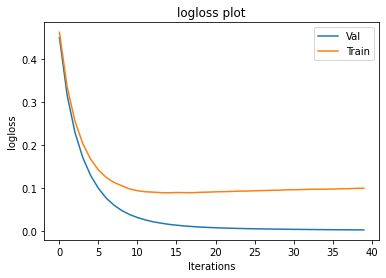

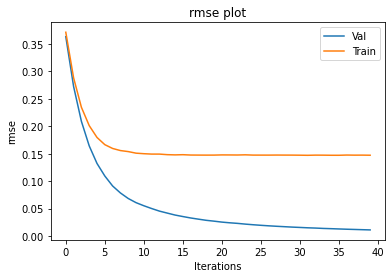

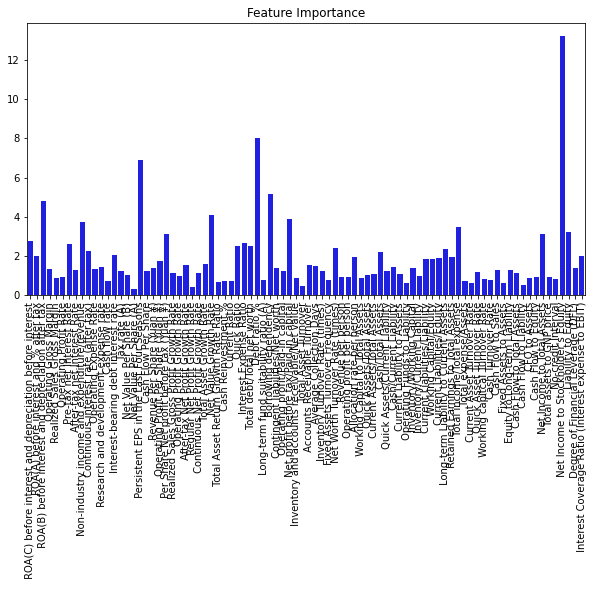

In [288]:
def plot_xgb(params,scores,epo):
    for m in params:
        test_ = scores['validation_0'][m]
        train_ = scores['validation_1'][m]
        rang = range(0, epo)
        
        plt.plot(rang, test_, label="Val")
        plt.plot(rang, train_, label="Train")
        plt.title(m + " plot")
        plt.xlabel('Iterations')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()


 
print(grid_estimator)
results = grid_estimator.best_estimator_.named_steps["clasification"].evals_result()
# grid_estimator.best_estimator_.evals_result()

plot_xgb(metrics,results,grid_estimator.best_params_['clasification__n_estimators'])


f, ax = plt.subplots(figsize=(10,5))
# Plot of features

keys  = evaluation_dataset.columns.to_list() 
yy = grid_estimator.best_estimator_.named_steps["clasification"].feature_importances_

feature_important  = grid_estimator.best_estimator_.named_steps["clasification"].get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
yy = list(feature_important.values())


plot = sns.barplot(x=keys, y=yy, color='blue')
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()

## Saving trained model

In [289]:
with open(OUTPUT_MODEL, "wb") as handle:
    pickle.dump(grid_estimator, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Saving metadata

In [290]:
current_variables = dir()

results_string = ""

for variable in current_variables:
    # Skip environment variables and their container variable
    # Ignore also underscore variables
    if variable in environment_variables or variable == "environment_variables" or variable.startswith("_"):
        continue

    # Get variables value
    variable_value = globals()[variable]

    # If variable is numerical or string, append it to results
    if type(variable_value) is str or type(variable_value) is int or \
        type(variable_value) is float or type(variable_value) is list or \
        type(variable_value) is numpy.float64 or type(variable_value) is dict:
        results_string += f"{variable}: {variable_value}\n"

# Print results to screen
# for line in results_string:
print(f'{results_string}')

# Save results to file
with open(OUTPUT_RESULTS, "w") as file:
    file.write(results_string)

CROSS_VALIDATION_CV: 5
HYPER_PARAMETER_CLASS_WEIGHT: balanced
HYPER_PARAMETER_GAMMA: ['scale']
HYPER_PARAMETER_KERNEL: ['rbf']
HYPER_PARAMETER_OPTIMIZATION_CV: 2
HYPER_PARAMETER_OPTIMIZATION_SCORING: accuracy
INPUT_EVALUATION_FILE: ../data/original/evaluation_dataset.csv
INPUT_TRAINING_FILE: ../data/original/training_dataset.csv
LABELS: ['Operational', 'Bankrupt']
METHOD_NAME: xgboost
OUTPUT_MODEL: ../data/models/xgboost_model_09_05_2022-23_49_44.pkl
OUTPUT_RESULTS: ../data/results/xgboost_model_09_05_2022-23_49_44.txt
PUNISHMENT_FOR_FALSE_BANKRUPT_PREDICTION: 100
RANDOM_SEED: 42
TIMESTAMP: 09_05_2022-23_49_44
evaluation_accuracy: 0.6465909090909091
evaluation_confusion_matrix: True operational=1317, True bankrupt=13, False operational=3, False bankrupt=31
feature_important: {' ROA(C) before interest and depreciation before interest': 2.775005578994751, ' ROA(A) before interest and % after tax': 1.9771093130111694, ' ROA(B) before interest and depreciation after tax': 4.808743000030518